In [1]:
import pandas as pd
import numpy as np
import sklearn
from collections import defaultdict
import regex as re
# nlp libraries
import string

from sklearn.metrics import classification_report


from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
dirty_df = pd.read_csv('advanced_trainset.csv')
dirty_df.head()

,Sentence,Sentiment
0,According to the Finnish-Russian Chamber of Co...,neutral
1,The Swedish buyout firm has sold its remaining...,neutral
2,$SPY wouldn't be surprised to see a green close,positive
3,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
4,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative


# Introduction

## Get the Data

A collection of texts is also sometimes called "corpus". Let's print the first ten messages and number them using **enumerate**:

In [3]:
dirty_df.Sentence[:10]

0    According to the Finnish-Russian Chamber of Co...
1    The Swedish buyout firm has sold its remaining...
2      $SPY wouldn't be surprised to see a green close
3    Shell's $70 Billion BG Deal Meets Shareholder ...
4    SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...
5    The Stockmann department store will have a tot...
6    Circulation revenue has increased by 5 % in Fi...
7    $SAP Q1 disappoints as #software licenses down...
8    The subdivision made sales revenues last year ...
9             Viking Line has canceled some services .
Name: Sentence, dtype: object

In [4]:
for message_no, message in enumerate(dirty_df.Sentence[:10]):
    print(message_no, message)
    print('\n')

0 According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .


1 The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .


2 $SPY wouldn't be surprised to see a green close


3 Shell's $70 Billion BG Deal Meets Shareholder Skepticism


4 SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANGE RELEASE OCTOBER 14 , 2008 AT 2:45 PM The Company updates its full year outlook and estimates its results to remain at loss for the full year .


5 The Stockmann department store will have a total floor space of over 8,000 square metres and Stockmann 's investment in the project will have a price tag of about EUR 12 million .


6 Circulation revenue has increased by 5 % in Finland and 4 % in Sweden in 2008 .


7 $SAP Q1 disappoints as #software licenses down. Real problem? #Cloud growth trails $MSFT $ORCL $GOOG $CRM $ADBE https://t.co/jNDphllzq5


8 The subdi

We'll use **read_csv** and make note of the **sep** argument, we can also specify the desired column names by passing in a list of *names*.

## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [5]:
dirty_df.describe()

,Sentence,Sentiment
count,4382,4382
unique,4081,3
top,"In the first half of 2008 , the Bank 's operat...",neutral
freq,2,2363


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [6]:
dirty_df.groupby('Sentiment').describe()

Sentence                                                            \
             count unique                                                top   
Sentiment                                                                      
negative       636    636  Shell's $70 Billion BG Deal Meets Shareholder ...   
neutral       2363   2360  The company serves customers in various indust...   
positive      1383   1383    $SPY wouldn't be surprised to see a green close   

                
          freq  
Sentiment       
negative     1  
neutral      2  
positive     1

See how long the text messages are

In [7]:
dirty_df.to_csv('new.csv')

In [8]:
dirty_df['length'] = dirty_df['Sentence'].apply(len)
dirty_df.head()

,Sentence,Sentiment,length
0,According to the Finnish-Russian Chamber of Co...,neutral,128
1,The Swedish buyout firm has sold its remaining...,neutral,135
2,$SPY wouldn't be surprised to see a green close,positive,47
3,Shell's $70 Billion BG Deal Meets Shareholder ...,negative,56
4,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative,190


In [9]:
dirty_df.Sentiment.value_counts()

neutral     2363
positive    1383
negative     636
Name: Sentiment, dtype: int64

**There seems to be an imbalance in the dataset with small negative counts**

### Data Visualization

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<AxesSubplot:ylabel='Frequency'>

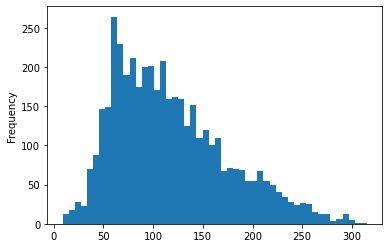

In [11]:
dirty_df['length'].plot(bins=50, kind='hist') 

Shortest message only contains up to quite a bit more than 300 words

In [12]:
dirty_df.length.describe()

count    4382.000000
mean      117.269968
std        56.811408
min         9.000000
25%        72.000000
50%       107.000000
75%       151.000000
max       315.000000
Name: length, dtype: float64

In [13]:
# See what's in the longest message
dirty_df[dirty_df['length'] == dirty_df.describe().loc['max'].values[0]]['Sentence'].iloc[0]

'Supported Nokia phones include : N96 , N95-8GB , N95 , N93-N931 , N92 , N85 , N82 , N81 , N80 , N79 , N78 , N77 , N76 , N75 , N73 , N72 , N71 , E90 , E71 , E70 , E66 , E65 , E62 , E61-E61i , E60 , E51 , E50 , Touch Xpress 5800 , 6220 Classic , 6210 Navigator , 6120 Classic , 6110 Navigator , 5700 , 5500 , 5320XM .'

See how those sentences with their sentiment

<AxesSubplot:>

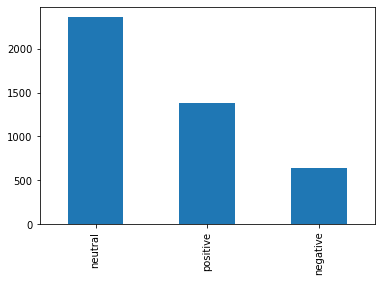

In [14]:
dirty_df.Sentiment.value_counts().plot(kind='bar')

array([[<AxesSubplot:title={'center':'negative'}>,
        <AxesSubplot:title={'center':'neutral'}>],
       [<AxesSubplot:title={'center':'positive'}>, <AxesSubplot:>]],
      dtype=object)

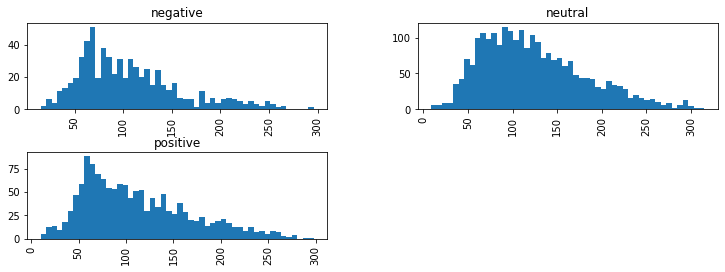

In [15]:
dirty_df.hist(column='length', by='Sentiment', bins=50,figsize=(12,4))

Everything follows a common trend: peaks around 50-100

neutral is unique

# Baseline model

In [16]:
cleaned = dirty_df.copy(deep=True)
cleaned["Sentence_cleaned"] = cleaned["Sentence"].str.lower()
# cleaned["Sentence_cleaned"] = cleaned["Sentence_cleaned"].str.replace(r",|\.", " ")
cleaned

,Sentence,Sentiment,length,Sentence_cleaned
0,According to the Finnish-Russian Chamber of Co...,neutral,128,according to the finnish-russian chamber of co...
1,The Swedish buyout firm has sold its remaining...,neutral,135,the swedish buyout firm has sold its remaining...
2,$SPY wouldn't be surprised to see a green close,positive,47,$spy wouldn't be surprised to see a green close
3,Shell's $70 Billion BG Deal Meets Shareholder ...,negative,56,shell's $70 billion bg deal meets shareholder ...
4,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative,190,ssh communications security corp stock exchang...
...,...,...,...,...
4377,Investments in product development stood at 6....,neutral,72,investments in product development stood at 6....
4378,HSBC Says Unit to Book $585 Million Charge on ...,negative,56,hsbc says unit to book $585 million charge on ...
4379,RISING costs have forced packaging producer Hu...,negative,107,rising costs have forced packaging producer hu...
4380,"In the building and home improvement trade , s...",neutral,88,"in the building and home improvement trade , s..."


In [17]:
words = defaultdict(int) # counting appearance of each word
for i in cleaned["Sentence_cleaned"]:
    for i in i.split():
        words[i] += 1
        
word_index = {} # find index of a word for feature engineering
counter = 0
for i in words:
    if words[i] > 1:
        word_index[i] = counter
        counter += 1
word_index[" "] = counter

In [18]:
word_count = [] # add number of appereances of the word based on the index
for sentence in cleaned["Sentence_cleaned"]:
    result = [0] * 5225 # total number of unique words that appear more than once
    for word in sentence.split(" "):
        if word in word_index:
            result[word_index[word]] += 1
    word_count.append(result)

# Feature engineering

In [19]:
df = pd.DataFrame(word_count)
df["length"] = cleaned["Sentence_cleaned"].str.split().apply(len) # length as additional feature
df.head()

,0,1,2,3,4,5,6,7,8,9,...,5216,5217,5218,5219,5220,5221,5222,5223,5224,length
0,1,1,2,2,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20
1,0,0,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4,0,1,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,34


## Model testing
We are trying out a few different classifers: Decision Tree, Random Forest & Ada Boost

In [20]:
# split the data into train & test set
X_train, X_test, y_train, y_test = train_test_split(df,cleaned["Sentiment"],test_size=0.25,random_state=69)

In [21]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
predictions =list(clf.predict(X_test)) 
print(classification_report(y_test, predictions))
# classification_report(y_test, predictions,output_dict=True)['accuracy']
acc = classification_report(y_test, predictions,output_dict=True)['accuracy']
f1_score = ''
print(f'Accuracy:{acc}')

              precision    recall  f1-score   support

    negative       0.32      0.38      0.35       159
     neutral       0.75      0.72      0.74       604
    positive       0.67      0.66      0.67       333

    accuracy                           0.65      1096
   macro avg       0.58      0.59      0.58      1096
weighted avg       0.66      0.65      0.66      1096

Accuracy:0.6523722627737226


In [22]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
predictions =list(clf.predict(X_test)) 
print(classification_report(y_test, predictions))
# classification_report(y_test, predictions,output_dict=True)['accuracy']
acc = classification_report(y_test, predictions,output_dict=True)['accuracy']
print(f'Accuracy:{acc}')

              precision    recall  f1-score   support

    negative       0.26      0.16      0.20       159
     neutral       0.72      0.85      0.78       604
    positive       0.73      0.62      0.67       333

    accuracy                           0.68      1096
   macro avg       0.57      0.54      0.55      1096
weighted avg       0.66      0.68      0.66      1096

Accuracy:0.6806569343065694


In [23]:
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
predictions =list(clf.predict(X_test)) 
print(classification_report(y_test, predictions))
# classification_report(y_test, predictions,output_dict=True)['accuracy']
acc = classification_report(y_test, predictions,output_dict=True)['accuracy']
print(f'Accuracy: {acc}')

              precision    recall  f1-score   support

    negative       0.47      0.22      0.30       159
     neutral       0.74      0.89      0.80       604
    positive       0.71      0.62      0.66       333

    accuracy                           0.71      1096
   macro avg       0.64      0.58      0.59      1096
weighted avg       0.69      0.71      0.69      1096

Accuracy: 0.7098540145985401


Based on models we have, Ada Boost Classifer has the best accuracy score

## Text Pre-processing

We proceed to a new method by removing punctuation and also use tf-idf model to put into our pipeline

In [24]:
import string

mess = 'Messs! Hello: Dollar sign $70 with other punctuations.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]
#  or '$' in char

# Join the characters again to form the string.
nopunc = ''.join(nopunc)
nopunc

'Messs Hello Dollar sign 70 with other punctuations'

Now let's see how to remove stopwords. We can impot a list of english stopwords from NLTK (check the documentation for more languages and info).

In [25]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've"]

In [26]:
# Remove any stopwords & make it lowercase
clean_mess = [word.lower() for word in nopunc.split() if word.lower() not in stopwords]
# or '$' in word.lower()
clean_mess

['messs', 'hello', 'dollar', 'sign', '70', 'with', 'other', 'punctuations']

Now let's put both of these together in a function to apply it to our DataFrame later on:

In [27]:
def clean_sentence(s):
    '''
    Remove selective puntuations & other sentence junk
    '''
    # To lowercase
    s = s.lower()

    # Remove apostrophes
    s = re.sub(' \'s', '', s)

    # Fix % and $ whitespace
    s = re.sub('(?<=\d) %', '%', s)
    s = re.sub('\$ (?=\d)', '$', s)

    # Remove links
    s = re.sub('http\S+', ' ', s)

    # Remove .'s not surrounded by numbers
    s = re.sub('(?<!\d)\.|\,(?!\d)', ' ', s)

    # Remove punctuation
    s = re.sub('-|\(|\)', ' ', s)
    s = re.sub('\'|\,|\`', '', s)

    # Remove extra whitespace
    s = re.sub(' +', ' ', s)

    return s

In [28]:
# Check to make sure its working
dirty_df['Sentence'].head(5).apply(clean_sentence)

0    according to the finnish russian chamber of co...
1    the swedish buyout firm has sold its remaining...
2       $spy wouldnt be surprised to see a green close
3    shells $70 billion bg deal meets shareholder s...
4    ssh communications security corp stock exchang...
Name: Sentence, dtype: object

In [29]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords]

In [30]:
# Check to make sure its working
dirty_df['Sentence'].head(5).apply(text_process)

0    [According, to, the, FinnishRussian, Chamber, ...
1    [The, Swedish, buyout, firm, has, sold, its, r...
2    [SPY, wouldnt, be, surprised, to, see, a, gree...
3    [Shells, 70, Billion, BG, Deal, Meets, Shareho...
4    [SSH, COMMUNICATIONS, SECURITY, CORP, STOCK, E...
Name: Sentence, dtype: object

### Tokenization
Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).


### Continuing Normalization

There are a lot of ways to continue normalizing this text. Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).

NLTK has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:
    
    'Nah dawg, IDK! Wut time u headin to da club?'
    
versus

    'No dog, I don't know! What time are you heading to the club?'
    
Some text normalization methods will have trouble with this type of shorthand and so I'll leave you to explore those more advanced methods through the [NLTK book online](http://www.nltk.org/book/).

For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.

## Vectorization

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [32]:
# Take a while
bow_transformer = CountVectorizer(analyzer=text_process).fit(dirty_df['Sentence'])

# Show total number of vocab words
print(len(bow_transformer.vocabulary_))

12300


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [33]:
message4 = dirty_df['Sentence'][3]
print(message4)

Shell's $70 Billion BG Deal Meets Shareholder Skepticism


Now let's see its vector representation:

In [34]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 1194)	1
  (0, 1764)	1
  (0, 1892)	1
  (0, 2440)	1
  (0, 4215)	1
  (0, 5488)	1
  (0, 5495)	1
  (0, 5550)	1
(1, 12300)


In [35]:
print(bow_transformer.get_feature_names()[10])
print(bow_transformer.get_feature_names()[50])

004
043


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [36]:
messages_bow = bow_transformer.transform(dirty_df['Sentence'])

In [37]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (4382, 12300)
Amount of Non-Zero occurences:  75188


In [38]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

In [39]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 5550)	0.39629165715027104
  (0, 5495)	0.3778061386922472
  (0, 5488)	0.3778061386922472
  (0, 4215)	0.39629165715027104
  (0, 2440)	0.31460373363129207
  (0, 1892)	0.33308925208931595
  (0, 1764)	0.32291593716252964
  (0, 1194)	0.29365324199362997


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"`?

In [40]:
# tfidf_transformer

In [41]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
# print(tfidf_transformer.idf_[bow_transformer.vocabulary_['']])

8.692341519858864


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [42]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(4382, 12300)


## Training a model

With messages represented as vectors, we can finally train our classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [43]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, dirty_df['Sentiment'])

Let's try classifying our single random message and checking how we do:

In [44]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', dirty_df.Sentiment[3])

predicted: positive
expected: negative


### Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [45]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['neutral' 'neutral' 'positive' ... 'neutral' 'neutral' 'positive']


We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

In [46]:
from sklearn.metrics import classification_report
print (classification_report(dirty_df['Sentiment'], all_predictions))

              precision    recall  f1-score   support

    negative       1.00      0.14      0.25       636
     neutral       0.69      1.00      0.81      2363
    positive       0.91      0.57      0.70      1383

    accuracy                           0.74      4382
   macro avg       0.87      0.57      0.59      4382
weighted avg       0.80      0.74      0.70      4382



In [47]:
from sklearn.metrics import accuracy_score
accuracy_score(dirty_df['Sentiment'], all_predictions)

0.7380191693290735

## Train Test Split

In [48]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(dirty_df['Sentence'], dirty_df['Sentiment'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

3505 877 4382


The test size is 20% of the entire dataset, and the training is the rest. Note the default split would have been 30/70.

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.neighbors import NearestNeighbors

In [50]:
pipeline_naive_bayes = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
#     ('decision_tree',  DecisionTreeClassifier(random_state=0)),
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [51]:
pipeline_tree = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('decision_tree',  DecisionTreeClassifier(random_state=0)),
#     ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [52]:
pipeline_adaboost = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('ada_boost',  AdaBoostClassifier()),
#     ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [53]:
pipeline_naive_bayes.fit(msg_train,label_train)
pipeline_tree.fit(msg_train,label_train)
pipeline_adaboost.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7fd778decd30>)),
                ('tfidf', TfidfTransformer()),
                ('ada_boost', AdaBoostClassifier())])

In [54]:
predictions_naive_bayes = pipeline_naive_bayes.predict(msg_test)
predictions_tree = pipeline_tree.predict(msg_test)
predictions_adaboost = pipeline_adaboost.predict(msg_test)

In [55]:
# new_df = df.copy()
# new_df['pred_nb'] = predictions_naive_bayes
# new_df['pred_tree'] = predictions_tree

In [56]:
# Tree
print(classification_report(predictions_tree,label_test))
accuracy_score(label_test, predictions_tree)

              precision    recall  f1-score   support

    negative       0.22      0.23      0.23       128
     neutral       0.67      0.63      0.65       497
    positive       0.53      0.58      0.55       252

    accuracy                           0.56       877
   macro avg       0.47      0.48      0.48       877
weighted avg       0.56      0.56      0.56       877



0.556442417331813

In [57]:
# Naive Bayes
print(classification_report(predictions_naive_bayes,label_test))
accuracy_score(label_test, predictions_naive_bayes)

              precision    recall  f1-score   support

    negative       0.04      1.00      0.09         6
     neutral       0.97      0.60      0.74       760
    positive       0.28      0.70      0.40       111

    accuracy                           0.61       877
   macro avg       0.43      0.77      0.41       877
weighted avg       0.88      0.61      0.69       877



0.6123147092360319

In [58]:
# Ada_boost
print(classification_report(predictions_adaboost,label_test))
accuracy_score(label_test, predictions_adaboost)

              precision    recall  f1-score   support

    negative       0.31      0.55      0.40        76
     neutral       0.81      0.70      0.75       538
    positive       0.59      0.62      0.60       263

    accuracy                           0.66       877
   macro avg       0.57      0.62      0.58       877
weighted avg       0.70      0.66      0.68       877



0.6624857468643102

# Ben functions classifer

In [59]:
pipeline_naive_bayes = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_sentence)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
#     ('decision_tree',  DecisionTreeClassifier(random_state=0)),
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
pipeline_tree = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('decision_tree',  DecisionTreeClassifier(random_state=0)),
#     ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
pipeline_adaboost = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('ada_boost',  AdaBoostClassifier()),
#     ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [60]:
pipeline_naive_bayes.fit(msg_train,label_train)
pipeline_tree.fit(msg_train,label_train)
pipeline_adaboost.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7fd778decd30>)),
                ('tfidf', TfidfTransformer()),
                ('ada_boost', AdaBoostClassifier())])

In [61]:
predictions_naive_bayes = pipeline_naive_bayes.predict(msg_test)
predictions_tree = pipeline_tree.predict(msg_test)
predictions_adaboost = pipeline_adaboost.predict(msg_test)

In [62]:
# Tree
print(classification_report(predictions_tree,label_test))
accuracy_score(label_test, predictions_tree)

              precision    recall  f1-score   support

    negative       0.22      0.23      0.23       128
     neutral       0.67      0.63      0.65       497
    positive       0.53      0.58      0.55       252

    accuracy                           0.56       877
   macro avg       0.47      0.48      0.48       877
weighted avg       0.56      0.56      0.56       877



0.556442417331813

In [63]:
# Naive Bayes
print(classification_report(predictions_naive_bayes,label_test))
accuracy_score(label_test, predictions_naive_bayes)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       0.99      0.56      0.72       818
    positive       0.12      0.58      0.20        59

    accuracy                           0.56       877
   macro avg       0.37      0.38      0.31       877
weighted avg       0.93      0.56      0.68       877



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5632839224629419

In [64]:
# Ada_boost
print(classification_report(predictions_adaboost,label_test))
accuracy_score(label_test, predictions_adaboost)

              precision    recall  f1-score   support

    negative       0.31      0.55      0.40        76
     neutral       0.81      0.70      0.75       538
    positive       0.59      0.62      0.60       263

    accuracy                           0.66       877
   macro avg       0.57      0.62      0.58       877
weighted avg       0.70      0.66      0.68       877



0.6624857468643102

### Naive Bayes was the only method that its accuracy plummeted after keeping the dollar signs & decimal numbers

# Ngrams method

In [65]:
df = dirty_df.copy(deep=True)
df['Sentence'] = df['Sentence'].apply(clean_sentence)
df["Sentiment"] = df['Sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
df

,Sentence,Sentiment,length
0,according to the finnish russian chamber of co...,0,128
1,the swedish buyout firm has sold its remaining...,0,135
2,$spy wouldnt be surprised to see a green close,1,47
3,shells $70 billion bg deal meets shareholder s...,-1,56
4,ssh communications security corp stock exchang...,-1,190
...,...,...,...
4377,investments in product development stood at 6....,0,72
4378,hsbc says unit to book $585 million charge on ...,-1,56
4379,rising costs have forced packaging producer hu...,-1,107
4380,in the building and home improvement trade sal...,0,88


Create ngrams from the size of n down to size 1 into a list for analysis

In [66]:
def create_ngrams(s, n):
    words = s.split()
    ngrams = []
    for i in range(n):
        to_zip = []
        for j in range(i + 1):
            start = j
            end = (-i + j)

            if start == 0 and end == 0:
                ngrams.append(words)
            elif start == 0:
                to_zip.append(words[:end])
            elif end == 0:
                to_zip.append(words[start:])
            else:
                to_zip.append(words[start:end])
        if i > 0:
            ngrams.append([' '.join(x) for x in list(zip(*to_zip))])
        
    return sum(ngrams, [])

create_ngrams('a b c d', 3)

['a', 'b', 'c', 'd', 'a b', 'b c', 'c d', 'a b c', 'b c d']

In [67]:
# Add ngrams list to the dataframe
df['ngrams'] = df['Sentence'].apply(create_ngrams, n=3)
df.head()

,Sentence,Sentiment,length,ngrams
0,according to the finnish russian chamber of co...,0,128,"[according, to, the, finnish, russian, chamber..."
1,the swedish buyout firm has sold its remaining...,0,135,"[the, swedish, buyout, firm, has, sold, its, r..."
2,$spy wouldnt be surprised to see a green close,1,47,"[$spy, wouldnt, be, surprised, to, see, a, gre..."
3,shells $70 billion bg deal meets shareholder s...,-1,56,"[shells, $70, billion, bg, deal, meets, shareh..."
4,ssh communications security corp stock exchang...,-1,190,"[ssh, communications, security, corp, stock, e..."


In [68]:
X_train, X_test, y_train, y_test = train_test_split(df.ngrams, df.Sentiment)

In [69]:
wordCount = defaultdict(int) # dictionary to put all the options for word of ngrams
# 
for s in df.Sentence:
    for w in create_ngrams(s, 3):
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
# Find popular ngrams
counts.reverse()

In [70]:
words = [x[1] for x in counts[:1000]]
wordId = dict(zip(words, range(len(words))))

In [71]:
def feature(ng):
    feat = [0]*len(words)
    for w in ng:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat

In [72]:
X_train_modified = [feature(ng) for ng in X_train]
X_test_modified = [feature(ng) for ng in X_test]

In [73]:
# Regularized regression
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X_train_modified, y_train)
theta = clf.coef_
preds = clf.predict(X_test_modified)

In [74]:
wordSort = list(zip(theta[:-1], words))
wordSort.sort()

In [75]:
print("1,000 most common n-grams")
print("--------------------------")
print()
print("most negative n-grams")
[print(w) for w in wordSort[:5]]
print()
print("most positive n-grams")
[print(w) for w in wordSort[:-6:-1]]
print()

1,000 most common n-grams
--------------------------

most negative n-grams
(-0.7105239105946056, 'down')
(-0.6498994205468586, 'long term')
(-0.6447199796804158, 'lower')
(-0.6281409603768257, 'fall')
(-0.6279235330045938, 'x')

most positive n-grams
(0.7002504509283916, 'grew')
(0.6149706723534387, 'positive')
(0.6067431505456121, 'rise')
(0.5743513178695382, 'improved')
(0.5640398192082151, 'same period of')



In [76]:
clf = linear_model.LogisticRegression()
clf.fit(X_train_modified, y_train)
predictions =list(clf.predict(X_test_modified)) 
print(classification_report(y_test, predictions))
acc = classification_report(y_test, predictions,output_dict=True)['accuracy']
print(f'Accuracy:{acc}')

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

          -1       0.35      0.23      0.28       162
           0       0.68      0.77      0.72       578
           1       0.66      0.61      0.63       356

    accuracy                           0.64      1096
   macro avg       0.56      0.54      0.55      1096
weighted avg       0.62      0.64      0.63      1096

Accuracy:0.6405109489051095


In [77]:
clf = RandomForestClassifier()
clf.fit(X_train_modified, y_train)
predictions =list(clf.predict(X_test_modified)) 
print(classification_report(y_test, predictions))
acc = classification_report(y_test, predictions,output_dict=True)['accuracy']
print(f'Accuracy:{acc}')

              precision    recall  f1-score   support

          -1       0.30      0.18      0.22       162
           0       0.68      0.83      0.75       578
           1       0.70      0.57      0.63       356

    accuracy                           0.65      1096
   macro avg       0.56      0.53      0.53      1096
weighted avg       0.63      0.65      0.63      1096

Accuracy:0.6505474452554745


In [78]:
clf = AdaBoostClassifier()
clf.fit(X_train_modified, y_train)
predictions =list(clf.predict(X_test_modified)) 
print(classification_report(y_test, predictions))
acc = classification_report(y_test, predictions,output_dict=True)['accuracy']
print(f'Accuracy:{acc}')

              precision    recall  f1-score   support

          -1       0.56      0.28      0.38       162
           0       0.64      0.89      0.74       578
           1       0.74      0.44      0.56       356

    accuracy                           0.65      1096
   macro avg       0.65      0.54      0.56      1096
weighted avg       0.66      0.65      0.63      1096

Accuracy:0.6532846715328468


# Combining N-grams and Bag of Words models
We are going to concatinate the n-gram model and the bag of words model together. We have the features from n-gram at the beginning of DataFrame and followed of the features of Bag of Words.

In [79]:
word_count = [] # add number of appereances of the word based on the index
for sentence in X_train:
    result = [0] * 5225 # total number of unique words that appear more than once
    for word in sentence:
        if word in word_index:
            result[word_index[word]] += 1
    word_count.append(result + [len(sentence)])
    
word_count_2 = [] # add number of appereances of the word based on the index
for sentence in X_test:
    result = [0] * 5225 # total number of unique words that appear more than once
    for word in sentence:
        if word in word_index:
            result[word_index[word]] += 1
    word_count_2.append(result + [len(sentence)])

In [80]:
X_train_modified = pd.merge(pd.DataFrame([feature(ng) for ng in X_train]), 
                            pd.DataFrame(word_count), 
                            left_index=True, 
                            right_index=True)

X_test_modified = pd.merge(pd.DataFrame([feature(ng) for ng in X_test]), 
                            pd.DataFrame(word_count_2), 
                            left_index=True, 
                            right_index=True)


In [81]:
clf = RandomForestClassifier()
clf.fit(X_train_modified, y_train)
predictions =list(clf.predict(X_test_modified)) 
print(classification_report(y_test, predictions))
acc = classification_report(y_test, predictions,output_dict=True)['accuracy']
print(f'Accuracy:{acc}')

              precision    recall  f1-score   support

          -1       0.27      0.14      0.18       162
           0       0.67      0.87      0.76       578
           1       0.77      0.57      0.66       356

    accuracy                           0.67      1096
   macro avg       0.57      0.53      0.53      1096
weighted avg       0.64      0.67      0.64      1096

Accuracy:0.6651459854014599


In [82]:
clf = AdaBoostClassifier()
clf.fit(X_train_modified, y_train)
predictions =list(clf.predict(X_test_modified)) 
print(classification_report(y_test, predictions))
acc = classification_report(y_test, predictions,output_dict=True)['accuracy']
print(f'Accuracy:{acc}')

              precision    recall  f1-score   support

          -1       0.56      0.28      0.38       162
           0       0.65      0.89      0.75       578
           1       0.76      0.47      0.58       356

    accuracy                           0.67      1096
   macro avg       0.66      0.55      0.57      1096
weighted avg       0.67      0.67      0.64      1096

Accuracy:0.6651459854014599


# Future improvement

Our intention was to also touch a package called TextBlob that shows the subjectivity & also polarity scores of a sentence which are also the features that we should consider to determine the sentiment of a sentence.
https://textblob.readthedocs.io/en/dev/

# Predicting the test data
We are going to use the Bag of Words model from the Baseline model because it produces the best prediction. Now, we use 99% of the dataset of learning and only 1% for testing.

In [83]:
words = defaultdict(int) # counting appearance of each word
for i in cleaned["Sentence_cleaned"]:
    for i in i.split():
        words[i] += 1
        
word_index = {} # find index of a word for feature engineering
counter = 0
for i in words:
    if words[i] > 1:
        word_index[i] = counter
        counter += 1
word_index[" "] = counter

word_count = [] # add number of appereances of the word based on the index
for sentence in cleaned["Sentence_cleaned"]:
    result = [0] * 5225 # total number of unique words that appear more than once
    for word in sentence.split(" "):
        if word in word_index:
            result[word_index[word]] += 1
    word_count.append(result)

df = pd.DataFrame(word_count)
df["length"] = cleaned["Sentence_cleaned"].str.split().apply(len) # length as additional feature
df.head()

X_train, X_test, y_train, y_test = train_test_split(df,cleaned["Sentiment"],test_size=0.01,random_state=69)

clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
predictions =list(clf.predict(X_test)) 
print(classification_report(y_test, predictions))
# classification_report(y_test, predictions,output_dict=True)['accuracy']
acc = classification_report(y_test, predictions,output_dict=True)['accuracy']
print(f'Accuracy: {acc}')

              precision    recall  f1-score   support

    negative       0.60      0.43      0.50         7
     neutral       0.76      0.92      0.83        24
    positive       1.00      0.77      0.87        13

    accuracy                           0.80        44
   macro avg       0.79      0.70      0.73        44
weighted avg       0.80      0.80      0.79        44

Accuracy: 0.7954545454545454


In [84]:
df = pd.read_csv("advanced_testset.csv")
df["Sentence_cleaned"] = df["Sentence"].str.lower()

words = defaultdict(int) # counting appearance of each word
for i in df["Sentence_cleaned"]:
    for i in i.split():
        words[i] += 1
        
word_index = {} # find index of a word for feature engineering
counter = 0
for i in words:
    if words[i] > 1:
        word_index[i] = counter
        counter += 1
word_index[" "] = counter

word_count = [] # add number of appereances of the word based on the index
for sentence in df["Sentence_cleaned"]:
    result = [0] * 5225 # total number of unique words that appear more than once
    for word in sentence.split(" "):
        if word in word_index:
            result[word_index[word]] += 1
    word_count.append(result)

engineered = pd.DataFrame(word_count)
engineered["length"] = df["Sentence_cleaned"].str.split().apply(len) # length as additional feature
engineered.head()

,0,1,2,3,4,5,6,7,8,9,...,5216,5217,5218,5219,5220,5221,5222,5223,5224,length
0,1,1,1,1,1,1,1,1,2,1,...,0,0,0,0,0,0,0,0,0,14
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,36
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
4,0,0,0,0,0,0,0,1,2,0,...,0,0,0,0,0,0,0,0,0,20


## Predicting

In [85]:
predictions =list(clf.predict(engineered)) 

df = df.drop("Sentence_cleaned", axis = 1)
df["Sentiment"] = predictions

df.to_csv("predicted.csv")